In [1]:
from __future__ import print_function, division
from nilmtk import DataSet, HDFDataStore, TimeFrame
from os.path import join
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
from nilmtk.metrics import f1_score
from nilmtk.metrics import rms_error_power
from nilmtk.metrics import mean_normalized_error_power
from nilmtk.disaggregate import combinatorial_optimisation


In [2]:
building_number = 1
ds = DataSet('/nilmtk/data/iawe.h5') #('/nilmtk/data/ukdale.h5') #("/data/REDD/redd.h5")
print(ds.buildings)

OrderedDict([(1, Building(instance=1, dataset='iAWE'))])


In [3]:
train = DataSet('/nilmtk/data/REDD/redd.h5') #('/nilmtk/data/iawe.h5') #('/nilmtk/data/ukdale.h5') #("/data/REDD/redd.h5")
test = DataSet('/nilmtk/data/REDD/redd.h5') #('/nilmtk/data/iawe.h5') #('/nilmtk/data/ukdale.h5') #("/data/REDD/redd.h5")

In [4]:
elec = train.buildings[building_number].elec

In [5]:
mains = elec.mains()
df_all = mains.power_series_all_data() #df_all has a bunch of NaNs
df_all_noNan = df_all.dropna()
a = df_all_noNan.keys()
middleTime = a[int(math.floor(a.size/2))]
middleTimeStr = "%d-%02d-%02d %02d:%02d:%02d" % (middleTime.year, middleTime.month, middleTime.day, middleTime.hour, middleTime.minute, middleTime.second)

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [6]:
middleTimeStr

/opt/conda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/opt/conda/lib/python2.7/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/opt/conda/lib/python2.7/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/opt/conda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/opt/conda/lib/python2.7/site-packages/IPython/core/formatters.py:672: DeprecationWarning: PlainTextFormat

'2011-04-27 19:08:15'

In [7]:
train.set_window(end=middleTimeStr)
test.set_window(start=middleTimeStr)

train_elec = train.buildings[building_number].elec
test_elec = test.buildings[building_number].elec

top_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

In [8]:
co = combinatorial_optimisation.CombinatorialOptimisation()
co.train(top_train_elec, sample_period=60, resample=True)
outputAddress = "/nilmtk/data/iawe_CO.h5"
output = HDFDataStore(outputAddress, 'w')
co.disaggregate(test_elec.mains(), output, sample_period=60, resample=True)
output.close()

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Done training!


/nilmtk/nilmtk/metergroup.py:901: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warn("As a quick implementation we only get Good Sections from"


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Including vampire_power = 169.137329102 watts to model...
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Including vampire_power = 97

In [9]:
%matplotlib inline

/opt/conda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


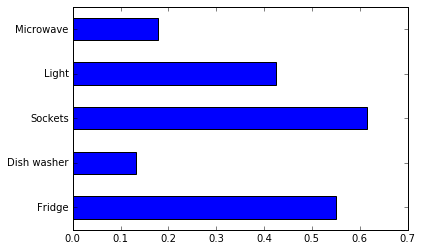

In [10]:
disag = DataSet(outputAddress) #load FHMM prediction
disag_elec = disag.buildings[building_number].elec
#disag_elec.plot() # plot all disaggregated data
f1 = f1_score(disag_elec, test_elec)
f1.index = disag_elec.get_labels(f1.index)
f1.plot(kind='barh')

KeyError: {'instance': 1, 'type': 'Fridge'}

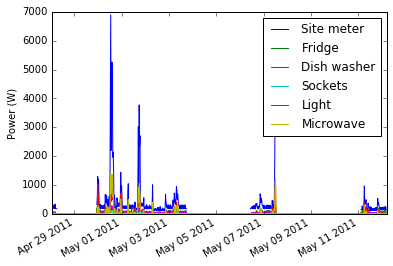

In [19]:
disag.store.window = TimeFrame(start='2011-04-28 00:00:00-05:00', end='2011-05-12 04:00:00-05:00') #2011-04-27
disag.buildings[building_number].elec.plot() # plot all disaggregated data


In [14]:
rms = rms_error_power(disag_elec, test_elec)

In [15]:
rms

5      83.053961
6     214.365159
8      29.420137
9      80.004423
11    238.215756
dtype: float64

In [16]:
mne = mean_normalized_error_power(disag_elec, test_elec)

In [17]:
mne

5     0.880193
6     2.785242
8     0.887510
9     1.015794
11    4.336999
dtype: float64

In [18]:
# Plot real and predict refrigerator consumption on six days of test data
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5))
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.ix[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)